## Отчет

В отчёте ответьте на вопросы:
   - Какие пункты плана были выполнены, а какие — нет (поясните почему)?
   - Какие трудности возникли и как вы их преодолели?
   - Какие ключевые шаги в решении задачи выделили?
   - Какая ваша итоговая модель и какое у неё качество?

1. Были выполнены все пункты плана, такие как: анализ, предобработка, работа с моделями, подбор лучших параметров и выбор наилучшей модели
2. Из трудностей могу выделить сам анализ данных, деление и объединение данных с помощью groupby а так же feature_importances_ 
3. Ключевые шаги:
    1. Анализ данных и выбор необходимых параметров для финального датасета, высчитал полною мощность
    2. Сортировка данных через groupby для финального датасета
    3. Убрал выбросы, проверил датасет, что в нем нет строк без присадок и нет продувки газа
    4. Проверил на корреляцию и убрал лишние столбцы
    5. Объединил все в финальный датасет и разделил на обучающую и тестовую выборки
    6. Было выбрано 4 модели: Линейная регрессия, Случайный лес, CatBoost, LGBM
    7. Была использована feature_importances_ для отображения важности признаков
    8. Из всех моделей лучше всего себя показала LGBM
4. Итоговая модель была LightGBM с результатом МАЕ на тестовой выборке 5.82

## Описание этапа обработки
- Промышленность — задача проекта.
- Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.dummy import DummyRegressor
from catboost import CatBoost, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

In [2]:
data_arc = pd.read_csv('D://Игорь/projects/final_steel/data_arc.csv') #данные об электродах
data_bulk = pd.read_csv('D://Игорь/projects/final_steel/data_bulk.csv') #данные о подаче сыпучих материалов (объём)
data_bulk_time = pd.read_csv('D://Игорь/projects/final_steel/data_bulk_time.csv') #данные о подаче сыпучих материалов (время)
data_gas = pd.read_csv('D://Игорь/projects/final_steel/data_gas.csv') #данные о продувке сплава газом
data_temp = pd.read_csv('D://Игорь/projects/final_steel/data_temp.csv') #результаты измерения температуры
data_wire = pd.read_csv('D://Игорь/projects/final_steel/data_wire.csv') #данные о проволочных материалах (объём)
data_wire_time = pd.read_csv('D://Игорь/projects/final_steel/data_wire_time.csv') #данные о проволочных материалах (время)

### data_arc

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
print('Строк и столбцов в данных об электродах:', data_arc.shape)
print('Количество пропусков в данных об электродах:', data_arc.duplicated().sum())

Строк и столбцов в данных об электродах: (14876, 5)
Количество пропусков в данных об электродах: 0


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Text(0.5, 1.0, 'Boxplot')

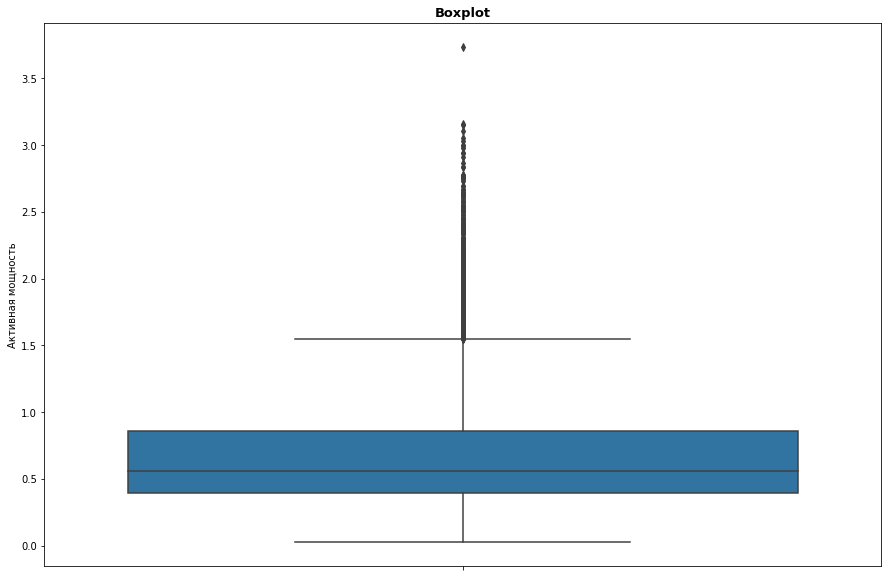

In [7]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data_arc, y='Активная мощность')
plt.title('Boxplot', fontsize=13, fontweight='bold')
#plt.ylim([0, 2])

(0.0, 5.0)

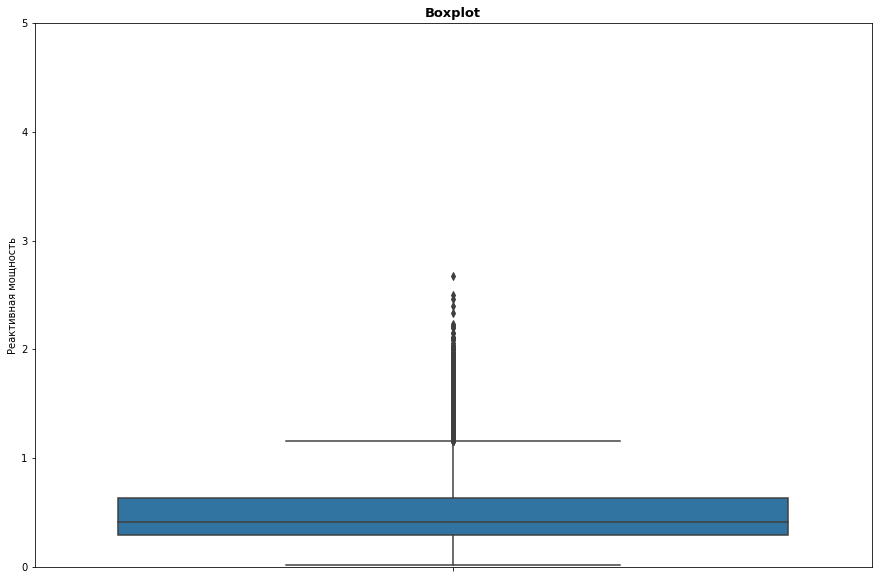

In [8]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data_arc, y='Реактивная мощность')
plt.title('Boxplot', fontsize=13, fontweight='bold')
plt.ylim([0, 5])

In [9]:
print(data_arc.sort_values(by = 'Реактивная мощность').head(10))

       key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   
5596  1216  2019-06-16 08:22:19  2019-06-16 08:22:30           0.030188   
2419   521  2019-05-22 17:42:57  2019-05-22 17:43:11           0.030563   
4914  1060  2019-06-11 04:31:57  2019-06-11 04:32:08           0.031630   
4633  1000  2019-06-09 01:17:44  2019-06-09 01:17:57           0.038186   
676    146  2019-05-08 19:18:55  2019-05-08 19:19:07           0.035400   
4063   873  2019-06-04 18:34:19  2019-06-04 18:34:30           0.040905   
6580  1432  2019-06-23 21:13:19  2019-06-23 21:13:34           0.034053   
8704  1892  2019-07-09 18:51:37  2019-07-09 18:51:50           0.038364   
4615   996  2019-06-08 22:06:27  2019-06-08 22:09:03           0.035165   

      Реактивная мощность  
9780          -715.504924  
5596             0.020806  
2419             0.021154  
4914             0.022485  
4633             0.022983  
676   

как видно у нас есть аномальное значение в столбце 'Реактивная мощность'

### data_bulk 

In [10]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [12]:
print('Строк и столбцов в данных подаче сыпучих материалов (объём):', data_bulk.shape)
print('Количество пропусков в данных подаче сыпучих материалов (объём):', data_bulk.duplicated().sum())

Строк и столбцов в данных подаче сыпучих материалов (объём): (3129, 16)
Количество пропусков в данных подаче сыпучих материалов (объём): 0


In [13]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### data_bulk_time

In [15]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [16]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [17]:
data_bulk_time.describe()


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [18]:
#здесь наверное лучше перевести в формат datetime

### data_gas

In [19]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [20]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
print('Строк и столбцов в данных о продувке сплава газом:', data_gas.shape)
print('Количество пропусков в данных о продувке сплава газом:', pd.isnull(data_gas).sum())

Строк и столбцов в данных о продувке сплава газом: (3239, 2)
Количество пропусков в данных о продувке сплава газом: key      0
Газ 1    0
dtype: int64


In [22]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Text(0.5, 1.0, 'Boxplot')

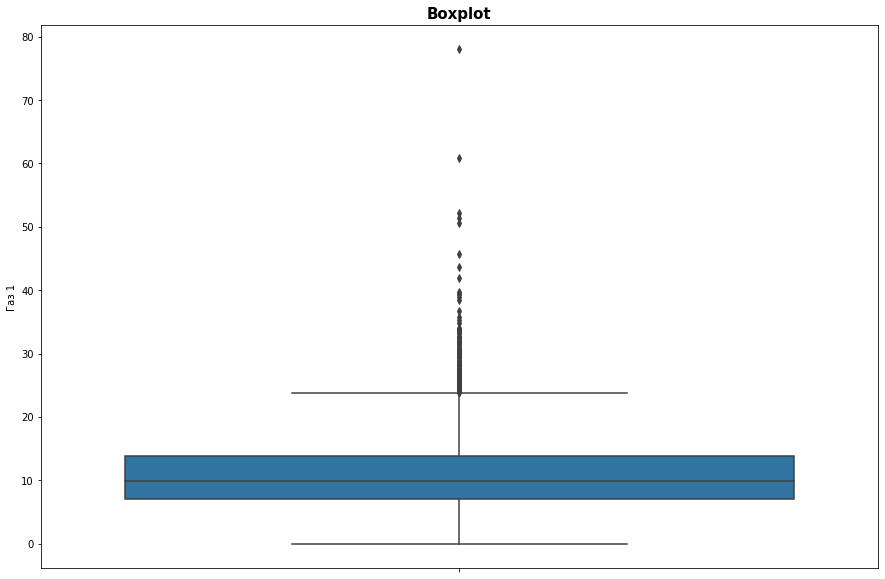

In [23]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data_gas, y='Газ 1')
plt.title('Boxplot', fontsize=15, fontweight='bold')
#plt.ylim([0, 4])

### data_temp

In [24]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [25]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [26]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [27]:
print('Строк и столбцов в данные о результатах измерения температуры:', data_temp.shape)
print('Количество пропусков в данные о результатах измерения температуры:', pd.isnull(data_temp).sum())

Строк и столбцов в данные о результатах измерения температуры: (15907, 3)
Количество пропусков в данные о результатах измерения температуры: key                0
Время замера       0
Температура     2901
dtype: int64


В столбце в температурой много пропусков но заменить нечем

Text(0.5, 1.0, 'Boxplot')

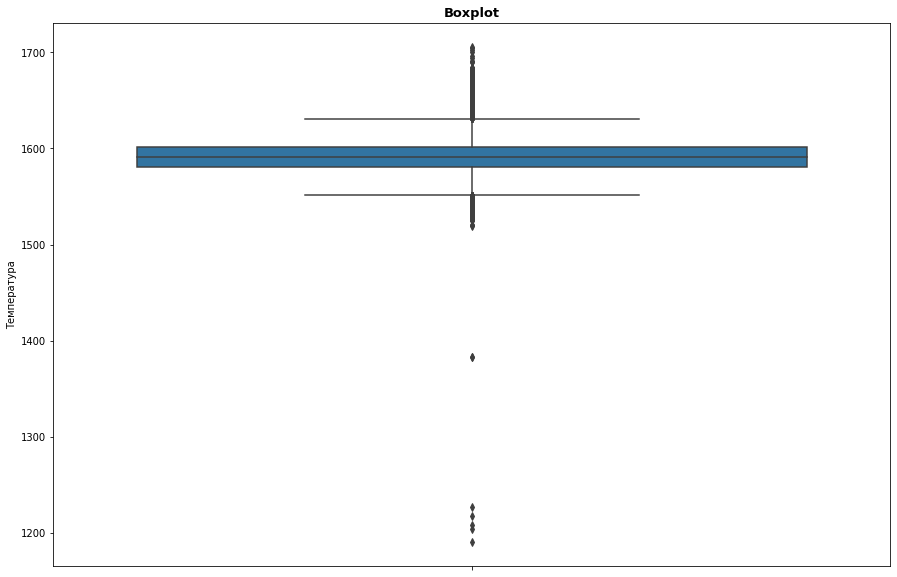

In [28]:
plt.figure(figsize=(15,10))
sns.boxplot(data=data_temp, y='Температура')
plt.title('Boxplot', fontsize=13, fontweight='bold')
#plt.ylim([0, 4])

### data_wire

In [29]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [31]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [32]:
print('Строк и столбцов в данных о проволочных материалах (объём):', data_wire.shape)
print('Количество пропусков в данных о результатах измерения температуры:', pd.isnull(data_wire).sum())

Строк и столбцов в данных о проволочных материалах (объём): (3081, 10)
Количество пропусков в данных о результатах измерения температуры: key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


### data_wire_time

In [33]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [35]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [36]:
print('Строк и столбцов в данных о проволочных материалах (время):', data_wire_time.shape)
print('Количество пропусков в данных о проволочных материалах (время):', pd.isnull(data_wire_time).sum())

Строк и столбцов в данных о проволочных материалах (время): (3081, 10)
Количество пропусков в данных о проволочных материалах (время): key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


### Вывод:
1. data_arc имелся выброс в данных, его необходимо удалить т.к. это единственное значение меньше 0
2. data_bulk и data_bulk_time взаимосвязаны, вероятнее всего их необходимо будет объединить
3. data_gas имеются выбросы но не кретичные
4. data_temp имеются пропуски но заменить их нечем по этому оставим их
5. data_wire и data_wire_time так же взаимосвязаны

6. Важность факторов:
    
    1. data_arc.csv — данные об электродах(нужны и полезны все столбцы)
    2. data_bulk.csv — данные о подаче сыпучих материалов (все столбцы нужны, заменить нечем)
    3. data_bulk_time.csv — данные о подаче сыпучих материалов (время)(данный датасет не нужен)
    4. data_gas.csv — данные о продувке сплава газом(данный датасет содержит всего 2 столбца, оба нужны);
    5. data_temp.csv — результаты измерения температуры(так же датасет содержит 2 столбца, оба нужны);
    6. data_wire.csv — данные о проволочных материалах (объём);
    7. data_wire_time.csv — данные о проволочных материалах (время)(данный датасет не нужен).







### План рабыты:
1. Сопоставляем данные температур с датами и выбираем самое последнее значение
2. Эти значения будут нашим датасетом
3. Т.к. ключевой признак количественный то задача регрессии
4. Выбираем из задач регрессии лучшую модель по средствам MAE

### План работы:  
- Провести исследовательский анализ данных:
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - Исключить партии, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
- Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Проверить признаки на мультиколлинеарность, исключить лишние
    - Провести масштабирование признаков
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую, валидационную и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность на валидационной выборке с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке

## Предобработка данных

Нужные датасеты:
1. data_arc
2. data_bulk
3. data_gas
4. data_temp
5. data_wire

#### to_datetime

In [37]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [38]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [39]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

In [40]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [41]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [42]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y%m%d %H:%M:%S')

In [43]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


В столбце температуры изменили формат в datetime

### меняем NaN на 0

In [44]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [45]:
data_bulk = data_bulk.fillna(0)

In [46]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [47]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
data_wire = data_wire.fillna(0)

In [49]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В датасетах dulk и wire поменяли все NaN на 0

### Выбросы

Text(0.5, 1.0, 'Boxplot')

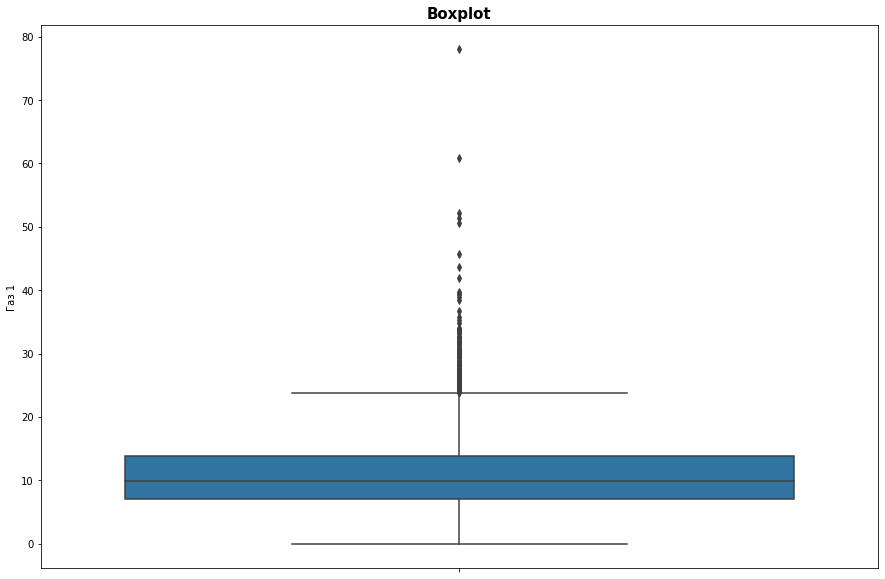

In [50]:
#data_gas
plt.figure(figsize=(15,10))
sns.boxplot(data=data_gas, y='Газ 1')
plt.title('Boxplot', fontsize=15, fontweight='bold')

In [51]:
data_gas['Газ 1'] = data_gas[data_gas['Газ 1'] <= 24]

In [52]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3117.000000
mean,1621.861377,1628.593519
std,935.386334,936.305427
min,1.000000,2.000000
25%,812.500000,825.000000
50%,1622.000000,1627.000000
75%,2431.500000,2439.000000
max,3241.000000,3241.000000


Text(0.5, 1.0, 'Boxplot')

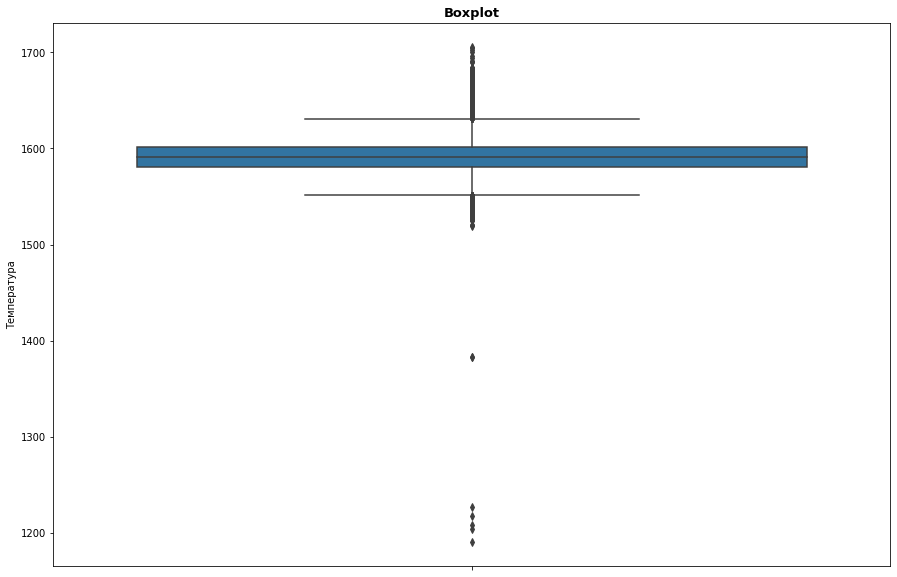

In [53]:
#data_temp
plt.figure(figsize=(15,10))
sns.boxplot(data=data_temp, y='Температура')
plt.title('Boxplot', fontsize=13, fontweight='bold')

In [54]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [55]:
data_temp = data_temp.dropna()

In [56]:
data_temp.isnull().sum()

key             0
Время замера    0
Температура     0
dtype: int64

### Мощность

In [57]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [58]:
data_arc['Полная мощность'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5

In [59]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
 5   Полная мощность       14876 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 697.4 KB


In [60]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


In [61]:
data_arc['Общее время нагрева дугой'] = ((data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])
                                         .dt.total_seconds().astype(int))

In [62]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


In [63]:
df_arc = data_arc.groupby(by="key").sum()

In [64]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Общее время нагрева дугой
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148


In [65]:
#ключ с открицательной реактивной мощностью
data_arc = data_arc[data_arc['key'] != 2116]

In [66]:
temp_count = (data_temp.groupby('key')['key'].count())\
[(data_temp.groupby('key')['key'].count()) > 1].index

#удаляем индексы с одним замером из датасета
data_temp = data_temp[data_temp['key'].isin(temp_count)]

In [67]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


In [69]:
gb = data_temp.groupby('key')
gb = gb.agg(
    first_date=('Время замера', np.min),
    last_date=('Время замера', np.max)
).reset_index()

In [70]:
df_temp = data_temp.merge(gb)

In [71]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12265 entries, 0 to 12264
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12265 non-null  int64         
 1   Время замера  12265 non-null  datetime64[ns]
 2   Температура   12265 non-null  float64       
 3   first_date    12265 non-null  datetime64[ns]
 4   last_date     12265 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1)
memory usage: 574.9 KB


In [72]:
df_temp

,key,Время замера,Температура,first_date,last_date
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:16:18,2019-05-03 11:30:39
1,1,2019-05-03 11:25:53,1604.0,2019-05-03 11:16:18,2019-05-03 11:30:39
2,1,2019-05-03 11:29:11,1618.0,2019-05-03 11:16:18,2019-05-03 11:30:39
3,1,2019-05-03 11:30:01,1601.0,2019-05-03 11:16:18,2019-05-03 11:30:39
4,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39
...,...,...,...,...,...
12260,2498,2019-08-06 02:19:26,1593.0,2019-08-06 02:03:49,2019-08-06 02:25:31
12261,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,2019-08-06 02:25:31
12262,2499,2019-08-06 02:40:25,1569.0,2019-08-06 02:40:25,2019-08-06 03:00:28
12263,2499,2019-08-06 02:54:24,1604.0,2019-08-06 02:40:25,2019-08-06 03:00:28


In [73]:
#dt - data_temp финальная
dt = df_temp.groupby('key')
dt = dt.agg(
    first_temp=('Температура', np.min),
    last_temp=('Температура', np.max)
).reset_index()

In [74]:
dtt = df_temp.groupby('key')['Температура'].first().reset_index()

In [75]:
dtt = dtt.rename(columns={"Температура" : "first_temp"})

In [76]:
dtt

,key,first_temp
0,1,1571.0
1,2,1581.0
2,3,1596.0
3,4,1601.0
4,5,1576.0
...,...,...
2470,2495,1570.0
2471,2496,1554.0
2472,2497,1571.0
2473,2498,1591.0


In [77]:
dttt = df_temp.groupby('key')['Температура'].last().reset_index()

In [78]:
dttt = dttt.rename(columns={"Температура" : "last_temp"})

In [79]:
dttt

,key,last_temp
0,1,1613.0
1,2,1602.0
2,3,1599.0
3,4,1625.0
4,5,1602.0
...,...,...
2470,2495,1591.0
2471,2496,1591.0
2472,2497,1589.0
2473,2498,1594.0


In [80]:
dtt = dtt.merge(dttt)

In [81]:
dtt.head()

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [82]:
dt = dt.merge(gb)

In [83]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         2475 non-null   int64         
 1   first_temp  2475 non-null   float64       
 2   last_temp   2475 non-null   float64       
 3   first_date  2475 non-null   datetime64[ns]
 4   last_date   2475 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 116.0 KB


In [84]:
dt['Время работы'] = ((dt['last_date'] - dt['first_date'])
                                         .dt.total_seconds().astype(int))

In [85]:
dt.head()

,key,first_temp,last_temp,first_date,last_date,Время работы
0,1,1571.0,1618.0,2019-05-03 11:16:18,2019-05-03 11:30:39,861
1,2,1577.0,1608.0,2019-05-03 11:37:27,2019-05-03 11:59:12,1305
2,3,1596.0,1599.0,2019-05-03 12:13:17,2019-05-03 12:34:57,1300
3,4,1601.0,1625.0,2019-05-03 12:52:57,2019-05-03 12:59:25,388
4,5,1576.0,1602.0,2019-05-03 13:23:19,2019-05-03 13:36:01,762


In [86]:
dt = dt.drop(columns = ['first_temp','last_temp'], axis = 1) 

In [87]:
dt = dt.merge(dtt)

In [88]:
dt.head()

,key,first_date,last_date,Время работы,first_temp,last_temp
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,861,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1305,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1300,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,388,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,762,1576.0,1602.0


1. data_arc
2. data_bulk
3. data_gas
4. data_temp
5. data_wire

In [89]:
#da data_arc финальная
da = data_arc.groupby('key')
da = da.agg(
    sum_power=('Полная мощность', np.sum),
    sum_heat=('Общее время нагрева дугой', np.sum)
).reset_index()

In [90]:
da

,key,sum_power,sum_heat
0,1,5.826395,1098
1,2,3.649216,811
2,3,2.989534,655
3,4,3.814962,741
4,5,4.035758,869
...,...,...,...
3208,3237,4.844982,909
3209,3238,2.696542,546
3210,3239,5.611883,1216
3211,3240,3.891856,839


In [91]:
df = dt

In [92]:
df = df.merge(da)

In [93]:
df = df.merge(data_bulk)

In [94]:
df = df.merge(data_gas)

In [95]:
df = df.merge(data_wire)

In [96]:
df = df.drop(['key'], axis=1)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   first_date    2328 non-null   datetime64[ns]
 1   last_date     2328 non-null   datetime64[ns]
 2   Время работы  2328 non-null   int64         
 3   first_temp    2328 non-null   float64       
 4   last_temp     2328 non-null   float64       
 5   sum_power     2328 non-null   float64       
 6   sum_heat      2328 non-null   int64         
 7   Bulk 1        2328 non-null   float64       
 8   Bulk 2        2328 non-null   float64       
 9   Bulk 3        2328 non-null   float64       
 10  Bulk 4        2328 non-null   float64       
 11  Bulk 5        2328 non-null   float64       
 12  Bulk 6        2328 non-null   float64       
 13  Bulk 7        2328 non-null   float64       
 14  Bulk 8        2328 non-null   float64       
 15  Bulk 9        2328 non-null   float64 

In [98]:
print('Количество строк без присадок и продувки газа:', df[df['first_date'] == df['last_date']].sum().sum())

Количество строк без присадок и продувки газа: 0.0


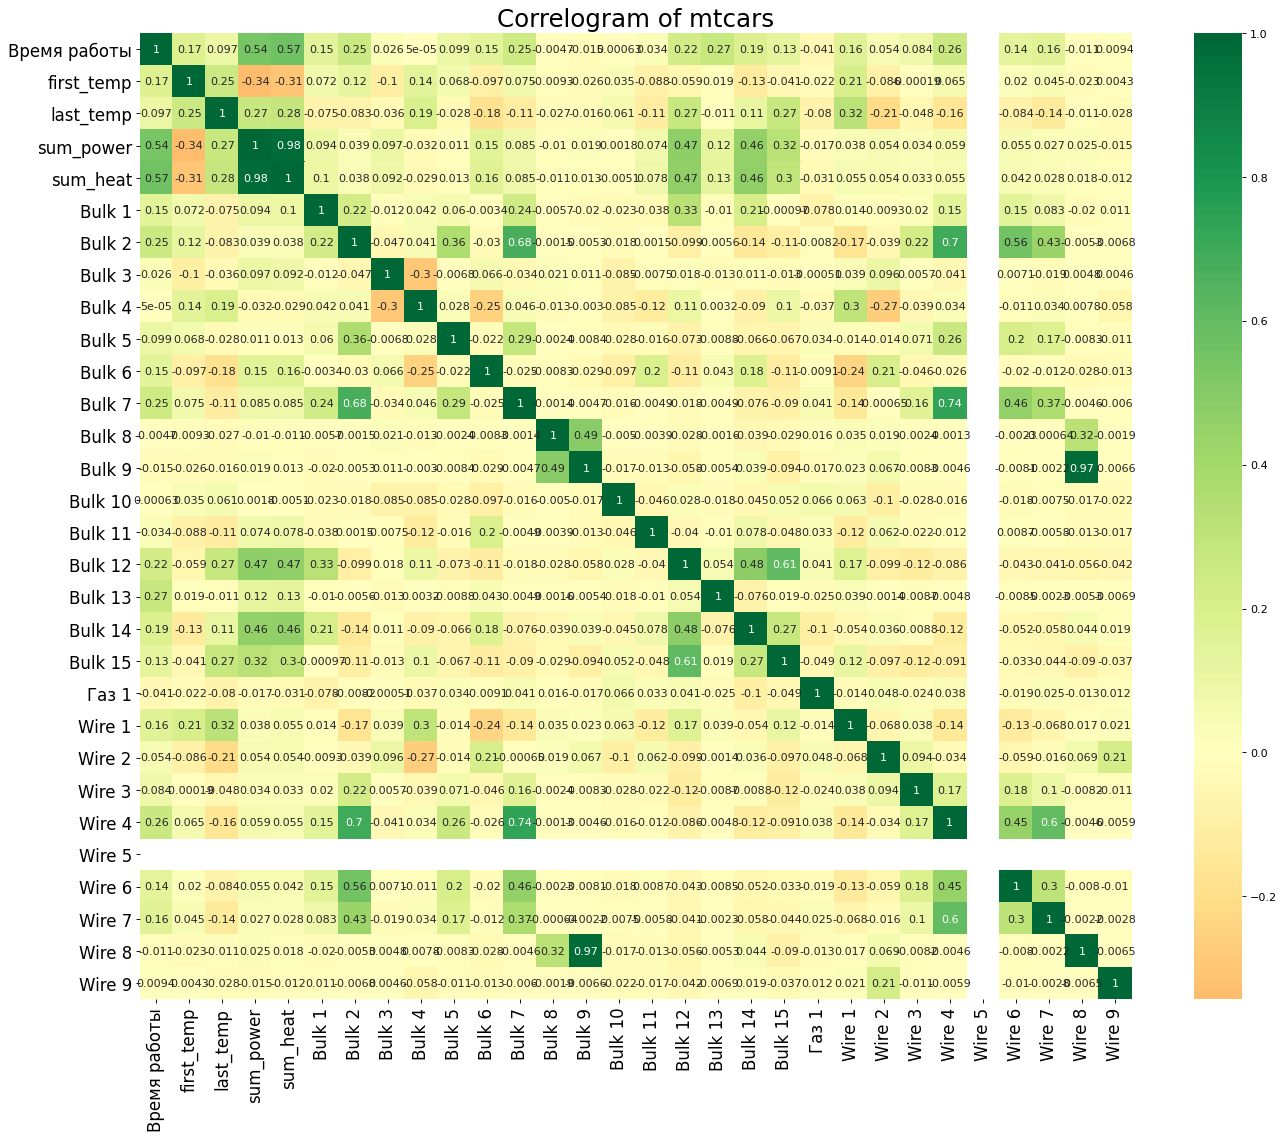

In [99]:
plt.figure(figsize=(20,16), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [100]:
#удаляем пустой и не нужные столбцы
df = df.drop(columns = ['first_date','last_date', 'Wire 5', 'sum_heat'], axis = 1) 

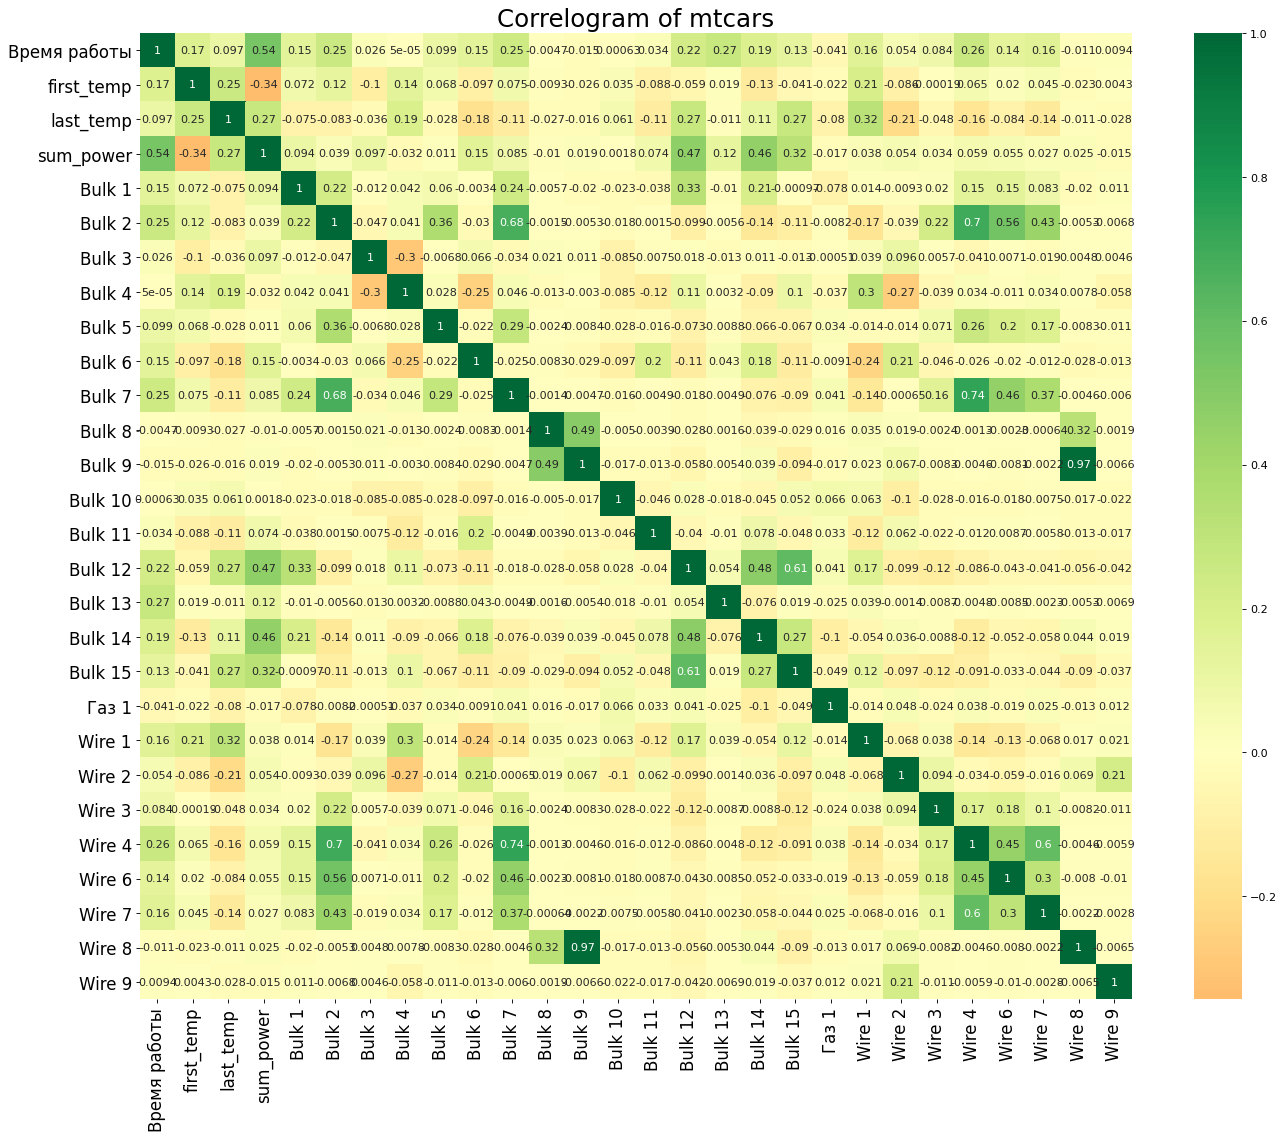

In [101]:
plt.figure(figsize=(20,16), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [102]:
df = df.dropna()

In [103]:
df['Время работы'] = df['Время работы'].astype(float)

### Вывод:
1. В столбце температуры изменили формат в datetime
2. В датасетах dulk и wire поменяли все NaN на 0
3. В дастасете темпаратуры убрали значения больше 34 т.к. являются выбросами
4. По формуле рассчитали полную мощность и общее время нагрева
5. расчитали полное время работы в temp
6. объединили все в один датасет df
7. Посмотрев корреляцию удалили из датасета 'Wire 5'
8. Так же из финального датасета были удалены датасета firs и last date из-за ненадобности и sum_heat из-за корреляци 0,98
9. В финале были удалены оставшиеся пропуски и переведены во float время работы и sum_heat

## Обучение модели

In [104]:
features = df.drop('last_temp', axis=1)
target = df['last_temp']

In [105]:
#делим на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=20220809)

честно говоря не получилось у меня сделать feature_importance, не подскажешь как корректно его сделать

In [106]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')
![image.png](attachment:image.png)

/bin/bash: -c: line 0: syntax error near unexpected token `attachment:image.png'
/bin/bash: -c: line 0: `[image.png](attachment:image.png)'


None


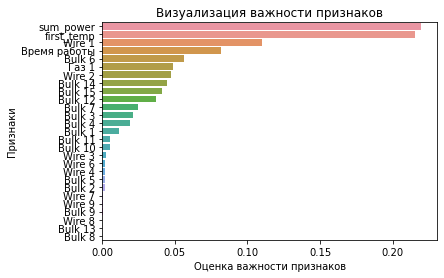

In [107]:
model = RandomForestRegressor(random_state=20220809)
model.fit(features_train, target_train)
print(chart_feature_imp(model))

Как и предполагалось, самые важные признаки - это полная мощность, температура, время работы. И еще wire 1 так же важен.

In [108]:
# Линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print(mean_absolute_error(target_test, predicted_test))

6.320859770581386


In [109]:
# Случайный лес
from sklearn.model_selection import TimeSeriesSplit
forest_model = RandomForestRegressor(random_state=20220809)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 15)}
forest_grid = GridSearchCV(forest_model, forest_params, scoring ='neg_mean_absolute_error', n_jobs=-1)
forest_grid.fit(features_train, target_train)
forest_prediction = forest_grid.predict(features_train)

print('Лучшие параметры случайного леса:', forest_grid.best_params_)
print('MAE случайного леса составляет:', mean_absolute_error(target_train, forest_prediction))

Лучшие параметры случайного леса: {'max_depth': 11, 'n_estimators': 40}
MAE случайного леса составляет: 3.0948274736977446


None


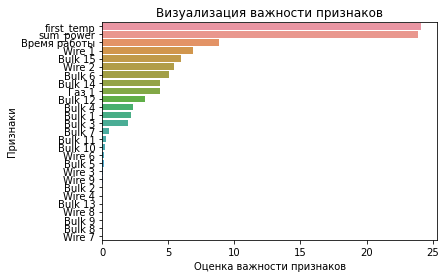

In [110]:
model = CatBoostRegressor(iterations=100, verbose=False, random_state=20220809,
                            learning_rate=0.1, depth=10)
model.fit(features_train, target_train)
print(chart_feature_imp(model))

Здесь явно видно что основными признаками являются начальная температура и общая мощность

In [111]:
catboost = CatBoostRegressor(iterations=100, verbose=False, random_state=20220809,
                            learning_rate=0.1, depth=10)
catboost.fit(features_train, target_train)
catboost_pred = catboost.predict(features_train)
print('MAE Catboost на обучающей выборке составляет:', mean_absolute_error(target_train, catboost_pred))

MAE Catboost на обучающей выборке составляет: 3.3856668960189293


None


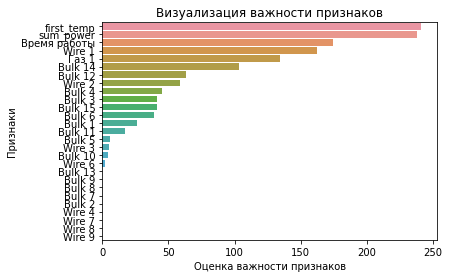

In [112]:
model = LGBMRegressor(random_state=20220809, n_estimators=100, num_leaves=15)
model.fit(features_train, target_train)
print(chart_feature_imp(model))

В LGBM более сбалансирована важность признаков, первичная температура, общая мощность в лидерах, время работы, wire, gas, все важно.

In [113]:
gbm_model = LGBMRegressor(random_state=20220809)
gbm_params = {'n_estimators':[100, 150], #количество деревьев решений
              'num_leaves':[10, 15, 20]} #количество терминальных узлов (листьев) дерева
gbm_grid = GridSearchCV(gbm_model, gbm_params, scoring ='neg_mean_absolute_error', n_jobs=-1)
gbm_grid.fit(features_train, target_train)
gbm_prediction = gbm_grid.predict(features_train)

print('Лучшие параметры LightGBM OE:', gbm_grid.best_params_)
print('MAE LightGBM составляет:', mean_absolute_error(target_train, gbm_prediction))

Лучшие параметры LightGBM OE: {'n_estimators': 100, 'num_leaves': 15}
MAE LightGBM составляет: 3.4453329345721246


### Обучение на тестовых данных

In [114]:
gbm_model_oe = LGBMRegressor(random_state=20220809, n_estimators=100, num_leaves=15)
gbm_model_oe.fit(features_train, target_train)
gbm_prediction_oe = gbm_model_oe.predict(features_test)

print('MAE составляет:', mean_absolute_error(target_test, gbm_prediction_oe))

MAE составляет: 5.82435637139551


### Вывод:
1. Были выбраны 4 машинного обучения:
     1. Линейная регрессия
     2. Случайный лес
     3. CatBoost
     4. LGBM
2. Были подобраны лучшие параметры для машинного обучения
3. Лучшее MAE показад LGBM с результатом 5.82, после идет catboost 5.85 и случайный лес 6.04. хуже всего показала себя линейная регрессия с результатом 6.32
4. Между LGBM и Catboost разница не существенна, однако лучше выбрать catboost из-за времени обучения. По сравнению с LGBM она обучается практически мгновенно.
5. Благодаря feature_importances_ быявлена важность признаков в разных моделях, более сбалансированной является так же LGBM.

## Общий вывод:

1. data_arc имелся выброс в данных, его необходимо удалить т.к. это единственное значение меньше 0
2. data_bulk и data_bulk_time взаимосвязаны, вероятнее всего их необходимо будет объединить
3. data_gas имеются выбросы но не кретичные
4. data_temp имеются пропуски но заменить их нечем по этому оставим их
5. data_wire и data_wire_time так же взаимосвязаны

6. В столбце температуры изменили формат в datetime
7. В датасетах dulk и wire поменяли все NaN на 0
8. В дастасете темпаратуры убрали значения больше 34 т.к. являются выбросами
9. По формуле рассчитали полную мощность и общее время нагрева
10. расчитали полное время работы в temp
11. объединили все в один датасет df
12. Посмотрев корреляцию удалили из датасета 'Wire 5'
13. Так же из финального датасета были удалены датасета firs и last date из-за ненадобности
14. В финале были удалены оставшиеся пропуски и переведены во float время работы и sum_heat

15. Были выбраны 4 машинного обучения:
    1. Линейная регрессия
    2. Случайный лес
    3. CatBoost
    4. LGBM
16. Были подобраны лучшие параметры для машинного обучения
17. Лучшее MAE показад LGBM с результатом 5.82, после идет catboost 5.85 и случайный лес 6.04. хуже всего показала себя линейная регрессия с результатом 6.32
18. Между LGBM и Catboost разница не существенна, однако лучше выбрать catboost из-за времени обучения. По сравнению с LGBM она обучается практически мгновенно.
19. Благодаря feature_importances_ быявлена важность признаков в разных моделях, более сбалансированной является так же LGBM.
